In [135]:
import math 
import torch
import os
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
# Make plots inline
# %matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

X_tensor = torch.randn(1000)
X_tensor_arr = X_tensor.detach().numpy()
X_tensor_arr.sort()
X_tensor = torch.tensor(X_tensor_arr)
min_x = torch.min(X_tensor).detach().numpy()
max_x = torch.max(X_tensor).detach().numpy()
inducing_points = torch.tensor(np.random.randn(150) * 10 - 5, )



In [136]:
#!/usr/bin/env python3
class SoRKernel(gpytorch.kernels.Kernel):
    def __init__(self, base_kernel, inducing_points, likelihood, active_dims=None):
        super(SoRKernel, self).__init__(active_dims=active_dims)
        self.base_kernel = base_kernel
        self.likelihood = likelihood

        if inducing_points.ndimension() == 1:
            inducing_points = inducing_points.unsqueeze(-1)
        if inducing_points.ndimension() != 2:
            raise RuntimeError("Inducing points should be 2 dimensional")
        self.register_parameter(name="inducing_points", parameter=torch.nn.Parameter(inducing_points))
        self.register_added_loss_term("inducing_point_loss_term")

    def train(self, mode=True):
        if hasattr(self, "_cached_kernel_mat"):
            del self._cached_kernel_mat
        return super(InducingPointKernel, self).train(mode)

    @property
    def _inducing_mat(self):
        if not self.training and hasattr(self, "_cached_kernel_mat"):
            return self._cached_kernel_mat
        else:
            res = gpytorch.lazy.delazify(self.base_kernel(self.inducing_points, self.inducing_points))
            if not self.training:
                self._cached_kernel_mat = res
            return res

    @property
    def _inducing_inv_root(self):
        if not self.training and hasattr(self, "_cached_kernel_inv_root"):
            return self._cached_kernel_inv_root
        else:
            chol = gpytorch.utils.cholesky.psd_safe_cholesky(self._inducing_mat, upper=True)
            eye = torch.eye(chol.size(-1), device=chol.device)
            inv_root = torch.trtrs(eye, chol)[0]

            res = inv_root
            if not self.training:
                self._cached_kernel_inv_root = res
            return res

    def _get_covariance(self, x1, x2):
        k_ux1 = gpytorch.lazy.delazify(self.base_kernel(x1, self.inducing_points))
        if torch.equal(x1, x2):
            covar = gpytorch.lazy.RootLazyTensor(k_ux1.matmul(self._inducing_inv_root))

            # Diagonal correction for predictive posterior
#             correction = (self.base_kernel(x1, x2, diag=True) - covar.diag()).clamp(0, math.inf)
#             covar = gpytorch.lazy.PsdSumLazyTensor(covar, gpytorch.lazy.DiagLazyTensor(correction))
        else:
            k_ux2 = gpytorch.lazy.delazify(self.base_kernel(x2, self.inducing_points))
            covar = gpytorch.lazy.MatmulLazyTensor(
                k_ux1.matmul(self._inducing_inv_root), k_ux2.matmul(self._inducing_inv_root).transpose(-1, -2)
            )

        return covar

    def _covar_diag(self, inputs):
        if inputs.ndimension() == 1:
            inputs = inputs.unsqueeze(1)

        # Get diagonal of covar
        covar_diag = gpytorch.lazy.delazify(self.base_kernel(inputs, diag=True))
        return gpytorch.lazy.DiagLazyTensor(covar_diag)

    def forward(self, x1, x2, diag=False, **kwargs):
        covar = self._get_covariance(x1, x2)

        if self.training:
            if not torch.equal(x1, x2):
                raise RuntimeError("x1 should equal x2 in training mode")
            zero_mean = torch.zeros_like(x1.select(-1, 0))
            new_added_loss_term = gpytorch.mlls.InducingPointKernelAddedLossTerm(
                gpytorch.distributions.MultivariateNormal(zero_mean, self._covar_diag(x1)),
                gpytorch.distributions.MultivariateNormal(zero_mean, covar),
                self.likelihood,
            )
            self.update_added_loss_term("inducing_point_loss_term", new_added_loss_term)

        if diag:
            return covar.diag()
        else:
            return covar

    def num_outputs_per_input(self, x1, x2):
        return self.base_kernel.num_outputs_per_input(x1, x2)

In [137]:
exact_gp_cov_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
exact_GP_cov = exact_gp_cov_module(X_tensor).evaluate().detach().numpy()

grid_size = 40
kiss_40_GP_cov_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            grid_size=grid_size, num_dims=1)
kiss_40_GP_cov = kiss_40_GP_cov_module(X_tensor).evaluate().detach().numpy()


grid_size = 150
kiss_150_GP_cov_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            grid_size=grid_size, num_dims=1)
kiss_150_GP_cov = kiss_150_GP_cov_module(X_tensor).evaluate().detach().numpy()

likelihood = gpytorch.likelihoods.GaussianLikelihood()

FITC_150_GP_cov_module = gpytorch.kernels.InducingPointKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            inducing_points=inducing_points,
            likelihood=likelihood).float()

FITC_150_GP_cov = FITC_150_GP_cov_module(X_tensor).evaluate().detach().numpy()

FITC_150_GP_cov_module = gpytorch.kernels.InducingPointKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            inducing_points=inducing_points,
            likelihood=likelihood).float()

FITC_150_GP_cov = FITC_150_GP_cov_module(X_tensor).evaluate().detach().numpy()



SoR_150_GP_module = SoRKernel(base_kernel=gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()), inducing_points=inducing_points, likelihood=likelihood).float()
SoR_150_GP_cov = SoR_150_GP_module(X_tensor).evaluate().detach().numpy()



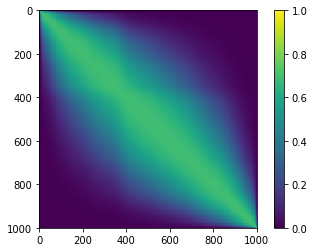

In [138]:
fig, ax = plt.subplots()
from matplotlib import colors
im = ax.imshow(exact_GP_cov, interpolation='nearest',vmin=0, vmax=1)
fig.colorbar(im)
plt.show()

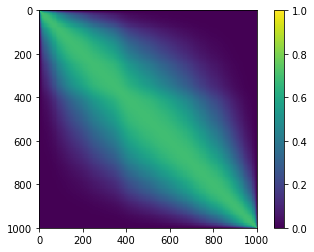

In [139]:
fig, ax = plt.subplots()
from matplotlib import colors
im = ax.imshow(kiss_40_GP_cov, interpolation='nearest',vmin=0, vmax=1)
fig.colorbar(im)
plt.show()

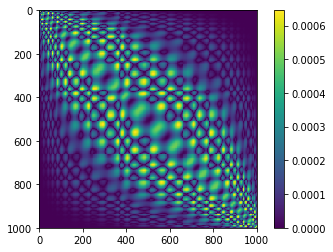

In [140]:
fig, ax = plt.subplots()
from matplotlib import colors
im = ax.imshow(abs(kiss_40_GP_cov-exact_GP_cov), interpolation='nearest')
fig.colorbar(im)
plt.show()

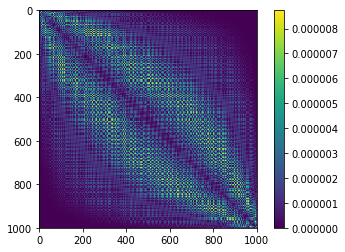

In [141]:
fig, ax = plt.subplots()
from matplotlib import colors
im = ax.imshow(abs(kiss_150_GP_cov-exact_GP_cov), interpolation='nearest')
fig.colorbar(im)
plt.show()

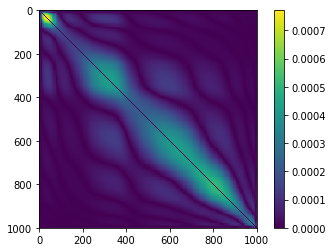

In [142]:
fig, ax = plt.subplots()
from matplotlib import colors
im = ax.imshow(abs(FITC_150_GP_cov-exact_GP_cov), interpolation='nearest')
fig.colorbar(im)
plt.show()


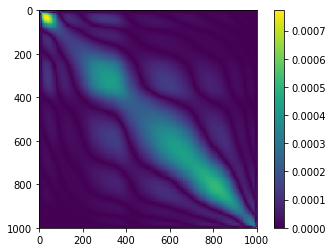

In [143]:
fig, ax = plt.subplots()
from matplotlib import colors
im = ax.imshow(abs(SoR_150_GP_cov-exact_GP_cov), interpolation='nearest')
fig.colorbar(im)
plt.show()

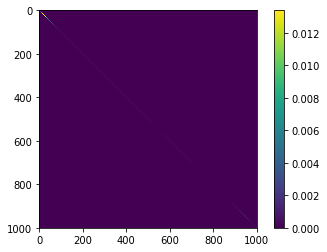

In [134]:
fig, ax = plt.subplots()
from matplotlib import colors
im = ax.imshow(abs(SoR_150_GP_cov-FITC_150_GP_cov), interpolation='nearest')
fig.colorbar(im)
plt.show()

# Extending interpolation class to handle linear interpolation

In [11]:
"""New interpolation class that handles linear interpolation as well"""
from gpytorch.utils.broadcasting import _matmul_broadcast_shape


class NewInterpolation(object):
    """
    """
    def __init__(self, interp_mode='linear'):
        self.interp_mode = interp_mode
    def _cubic_interpolation_kernel(self, scaled_grid_dist):
        """
        Computes the interpolation kernel u() for points X given the scaled
        grid distances:
                                    (X-x_{t})/s
        where s is the distance between neighboring grid points. Note that,
        in this context, the word "kernel" is not used to mean a covariance
        function as in the rest of the package. For more details, see the
        original paper Keys et al., 1989, equation (4).
        scaled_grid_dist should be an n-by-g matrix of distances, where the
        (ij)th element is the distance between the ith data point in X and the
        jth element in the grid.
        Note that, although this method ultimately expects a scaled distance matrix,
        it is only intended to be used on single dimensional data.
        """
        
        
        U = scaled_grid_dist.abs()
        res = torch.zeros(U.size(), dtype=U.dtype, device=U.device)

        U_lt_1 = 1 - U.floor().clamp(0, 1)  # U, if U < 1, 0 otherwise
        res = res + (((1.5 * U - 2.5).mul(U)).mul(U) + 1) * U_lt_1

        # u(s) = -0.5|s|^3 + 2.5|s|^2 - 4|s| + 2 when 1 < |s| < 2
        U_ge_1_le_2 = 1 - U_lt_1  # U, if U <= 1 <= 2, 0 otherwise
        res = res + (((-0.5 * U + 2.5).mul(U) - 4).mul(U) + 2) * U_ge_1_le_2
        return res

    def _linear_interpolation_kernel(self, scaled_grid_dist):
        """
        Computes the interpolation kernel u() for points X given the scaled
        grid distances:
                                    (X-x_{t})/s
        where s is the distance between neighboring grid points. Note that,
        in this context, the word "kernel" is not used to mean a covariance
        function as in the rest of the package. For more details, see the
        original paper Keys et al., 1989, equation (4).
        scaled_grid_dist should be an n-by-g matrix of distances, where the
        (ij)th element is the distance between the ith data point in X and the
        jth element in the grid.
        Note that, although this method ultimately expects a scaled distance matrix,
        it is only intended to be used on single dimensional data.
        """
        U = scaled_grid_dist.abs()
        res = torch.zeros(U.size(), dtype=U.dtype, device=U.device)

        U_lt_1 = 1 - U.floor().clamp(0, 1)  # U, if U < 1, 0 otherwise
        res = res + U * U_lt_1

#         # u(s) = -0.5|s|^3 + 2.5|s|^2 - 4|s| + 2 when 1 < |s| < 2
#         U_ge_1_le_2 = 1 - U_lt_1  # U, if U <= 1 <= 2, 0 otherwise
#         res = res + (((-0.5 * U + 2.5).mul(U) - 4).mul(U) + 2) * U_ge_1_le_2
        return res
    
    def interpolate(self, x_grid, x_target, interp_points=range(-2, 2)):
        if self.interp_mode == 'linear':
            self.interp_points=range(-1, 1)
        elif self.interp_mode == 'cubic':
            self.interp_points=range(-2, 2)
        else:
            raise (NotImplementedError)
        # Do some boundary checking
        grid_mins = x_grid.min(0)[0]
        grid_maxs = x_grid.max(0)[0]
        x_target_min = x_target.min(0)[0]
        x_target_max = x_target.min(0)[0]
        lt_min_mask = (x_target_min - grid_mins).lt(-1e-7)
        gt_max_mask = (x_target_max - grid_maxs).gt(1e-7)
        if lt_min_mask.sum().item():
            first_out_of_range = lt_min_mask.nonzero().squeeze(1)[0].item()
            raise RuntimeError(
                (
                    "Received data that was out of bounds for the specified grid. "
                    "Grid bounds were ({0:.3f}, {0:.3f}), but min = {0:.3f}, "
                    "max = {0:.3f}"
                ).format(
                    grid_mins[first_out_of_range].item(),
                    grid_maxs[first_out_of_range].item(),
                    x_target_min[first_out_of_range].item(),
                    x_target_max[first_out_of_range].item(),
                )
            )
        if gt_max_mask.sum().item():
            first_out_of_range = gt_max_mask.nonzero().squeeze(1)[0].item()
            raise RuntimeError(
                (
                    "Received data that was out of bounds for the specified grid. "
                    "Grid bounds were ({0:.3f}, {0:.3f}), but min = {0:.3f}, "
                    "max = {0:.3f}"
                ).format(
                    grid_mins[first_out_of_range].item(),
                    grid_maxs[first_out_of_range].item(),
                    x_target_min[first_out_of_range].item(),
                    x_target_max[first_out_of_range].item(),
                )
            )

        # Now do interpolation
        interp_points = torch.tensor(interp_points, dtype=x_grid.dtype, device=x_grid.device)
        interp_points_flip = interp_points.flip(0)

        num_grid_points = x_grid.size(0)
        num_target_points = x_target.size(0)
        num_dim = x_target.size(-1)
        num_coefficients = len(interp_points)

        interp_values = torch.ones(
            num_target_points, num_coefficients ** num_dim, dtype=x_grid.dtype, device=x_grid.device
        )
        interp_indices = torch.zeros(
            num_target_points, num_coefficients ** num_dim, dtype=torch.long, device=x_grid.device
        )

        for i in range(num_dim):
            grid_delta = x_grid[1, i] - x_grid[0, i]
            lower_grid_pt_idxs = torch.floor((x_target[:, i] - x_grid[0, i]) / grid_delta).squeeze()
            lower_pt_rel_dists = (x_target[:, i] - x_grid[0, i]) / grid_delta - lower_grid_pt_idxs
            lower_grid_pt_idxs = lower_grid_pt_idxs - interp_points.max()
            lower_grid_pt_idxs.detach_()

            if len(lower_grid_pt_idxs.shape) == 0:
                lower_grid_pt_idxs = lower_grid_pt_idxs.unsqueeze(0)

            scaled_dist = lower_pt_rel_dists.unsqueeze(-1) + interp_points_flip.unsqueeze(-2)
            if self.interp_mode == 'linear':
                dim_interp_values = self._linear_interpolation_kernel(scaled_dist)
            elif self.interp_mode == 'cubic':
                dim_interp_values = self._cubic_interpolation_kernel(scaled_dist)
            else:
                raise (NotImplementedError)
            # Find points who's closest lower grid point is the first grid point
            # This corresponds to a boundary condition that we must fix manually.
            left_boundary_pts = torch.nonzero(lower_grid_pt_idxs < 1)
            num_left = len(left_boundary_pts)

            if num_left > 0:
                left_boundary_pts.squeeze_(1)
                x_grid_first = x_grid[:num_coefficients, i].unsqueeze(1).t().expand(num_left, num_coefficients)

                grid_targets = x_target.select(1, i)[left_boundary_pts].unsqueeze(1).expand(num_left, num_coefficients)
                dists = torch.abs(x_grid_first - grid_targets)
                closest_from_first = torch.min(dists, 1)[1]

                for j in range(num_left):
                    dim_interp_values[left_boundary_pts[j], :] = 0
                    dim_interp_values[left_boundary_pts[j], closest_from_first[j]] = 1
                    lower_grid_pt_idxs[left_boundary_pts[j]] = 0

            right_boundary_pts = torch.nonzero(lower_grid_pt_idxs > num_grid_points - num_coefficients)
            num_right = len(right_boundary_pts)

            if num_right > 0:
                right_boundary_pts.squeeze_(1)
                x_grid_last = x_grid[-num_coefficients:, i].unsqueeze(1).t().expand(num_right, num_coefficients)

                grid_targets = x_target.select(1, i)[right_boundary_pts].unsqueeze(1)
                grid_targets = grid_targets.expand(num_right, num_coefficients)
                dists = torch.abs(x_grid_last - grid_targets)
                closest_from_last = torch.min(dists, 1)[1]

                for j in range(num_right):
                    dim_interp_values[right_boundary_pts[j], :] = 0
                    dim_interp_values[right_boundary_pts[j], closest_from_last[j]] = 1
                    lower_grid_pt_idxs[right_boundary_pts[j]] = num_grid_points - num_coefficients

            offset = (interp_points - interp_points.min()).long().unsqueeze(-2)
            dim_interp_indices = lower_grid_pt_idxs.long().unsqueeze(-1) + offset

            n_inner_repeat = num_coefficients ** i
            n_outer_repeat = num_coefficients ** (num_dim - i - 1)
            index_coeff = num_grid_points ** (num_dim - i - 1)
            dim_interp_indices = dim_interp_indices.unsqueeze(-1).repeat(1, n_inner_repeat, n_outer_repeat)
            dim_interp_values = dim_interp_values.unsqueeze(-1).repeat(1, n_inner_repeat, n_outer_repeat)
            interp_indices = interp_indices.add(dim_interp_indices.view(num_target_points, -1).mul(index_coeff))
            interp_values = interp_values.mul(dim_interp_values.view(num_target_points, -1))

        return interp_indices, interp_values


    def left_interp(interp_indices, interp_values, rhs):
        """
        """
        is_vector = rhs.ndimension() == 1

        if is_vector:
            res = rhs.index_select(0, interp_indices.view(-1)).view(*interp_values.size())
            res = res.mul(interp_values)
            res = res.sum(-1)
            return res

        else:
            num_rows, num_interp = interp_indices.shape[-2:]
            num_data, num_columns = rhs.shape[-2:]
            interp_shape = torch.Size((*interp_indices.shape[:-1], num_data))
            output_shape = _matmul_broadcast_shape(interp_shape, rhs.shape)
            batch_shape = output_shape[:-2]

            interp_indices_expanded = interp_indices.unsqueeze(-1).expand(*batch_shape, num_rows, num_interp, num_columns)
            interp_values_expanded = interp_values.unsqueeze(-1).expand(*batch_shape, num_rows, num_interp, num_columns)
            rhs_expanded = rhs.unsqueeze(-2).expand(*batch_shape, num_data, num_interp, num_columns)
            res = rhs_expanded.gather(-3, interp_indices_expanded).mul(interp_values_expanded)
            return res.sum(-2)


    def left_t_interp(interp_indices, interp_values, rhs, output_dim):
        """
        """
        from .. import dsmm

        is_vector = rhs.ndimension() == 1
        if is_vector:
            rhs = rhs.unsqueeze(-1)

        # Multiply the rhs by the interp_values
        # This multiplication here will give us the ability to perform backprop
        values = (rhs.unsqueeze(-2) * interp_values.unsqueeze(-1))

        # Define a bunch of sizes
        num_data, num_interp = interp_values.shape[-2:]
        num_cols = rhs.size(-1)
        interp_shape = torch.Size((*interp_indices.shape[:-2], output_dim, num_data))
        output_shape = _matmul_broadcast_shape(interp_shape, rhs.shape)
        batch_shape = output_shape[:-2]
        batch_size = batch_shape.numel()

        # Using interp_indices, create a sparse matrix that will sum up the values
        interp_indices = interp_indices.expand(*batch_shape, *interp_indices.shape[-2:]).contiguous()
        batch_indices = torch.arange(0, batch_size, dtype=torch.long, device=values.device).unsqueeze_(1)
        batch_indices = batch_indices.repeat(1, num_data * num_interp)
        column_indices = torch.arange(0, num_data * num_interp, dtype=torch.long, device=values.device).unsqueeze_(1)
        column_indices = column_indices.repeat(batch_size, 1)
        summing_matrix_indices = torch.stack([batch_indices.view(-1), interp_indices.view(-1), column_indices.view(-1)], 0)
        summing_matrix_values = torch.ones(
            batch_size * num_data * num_interp, dtype=interp_values.dtype, device=interp_values.device
        )
        size = torch.Size((batch_size, output_dim, num_data * num_interp))
        type_name = summing_matrix_values.type().split(".")[-1]  # e.g. FloatTensor
        if interp_values.is_cuda:
            cls = getattr(torch.cuda.sparse, type_name)
        else:
            cls = getattr(torch.sparse, type_name)
        summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)

        # Sum up the values appropriately by performing sparse matrix multiplication
        values = values.contiguous().view(batch_size, num_data * num_interp, num_cols)
        res = dsmm(summing_matrix, values)

        res = res.view(*batch_shape, *res.shape[-2:])
        if is_vector:
            res = res.squeeze(-1)
        return res

In [12]:
"""reimplementing GridInterpolationKernel to handle linear interpolation """

from gpytorch.kernels.grid_kernel import GridKernel
from gpytorch.lazy import InterpolatedLazyTensor
from gpytorch.models.exact_prediction_strategies import InterpolatedPredictionStrategy
from gpytorch.utils.interpolation import Interpolation
class NewGridInterpolationKernel(GridKernel):
    r"""
    Implements the KISS-GP (or SKI) approximation for a given kernel.
    It was proposed in `Kernel Interpolation for Scalable Structured Gaussian Processes`_,
    and offers extremely fast and accurate Kernel approximations for large datasets.
    Given a base kernel `k`, the covariance :math:`k(\mathbf{x_1}, \mathbf{x_2})` is approximated by
    using a grid of regularly spaced *inducing points*:
    .. math::
       \begin{equation*}
          k(\mathbf{x_1}, \mathbf{x_2}) = \mathbf{w_{x_1}}^\top K_{U,U} \mathbf{w_{x_2}}
       \end{equation*}
    where
    * :math:`U` is the set of gridded inducing points
    * :math:`K_{U,U}` is the kernel matrix between the inducing points
    * :math:`\mathbf{w_{x_1}}` and :math:`\mathbf{w_{x_2}}` are sparse vectors based on
      :math:`\mathbf{x_1}` and :math:`\mathbf{x_2}` that apply cubic interpolation.
    The user should supply the size of the grid (using the :attr:`grid_size` attribute).
    To choose a reasonable grid value, we highly recommend using the
    :func:`gpytorch.utils.grid.choose_grid_size` helper function.
    The bounds of the grid will automatically be determined by data.
    (Alternatively, you can hard-code bounds using the :attr:`grid_bounds`, which
    will speed up this kernel's computations.)
    .. note::
        `GridInterpolationKernel` can only wrap **stationary kernels** (such as RBF, Matern,
        Periodic, Spectral Mixture, etc.)
    Args:
        - :attr:`base_kernel` (Kernel):
            The kernel to approximate with KISS-GP
        - :attr:`grid_size` (int):
            The size of the grid (in each dimension)
        - :attr:`num_dims` (int):
            The dimension of the input data. Required if `grid_bounds=None`
        - :attr:`grid_bounds` (tuple(float, float), optional):
            The bounds of the grid, if known (high performance mode).
            The length of the tuple must match the number of dimensions.
            The entries represent the min/max values for each dimension.
        - :attr:`active_dims` (tuple of ints, optional):
            Passed down to the `base_kernel`.
    .. _Kernel Interpolation for Scalable Structured Gaussian Processes:
        http://proceedings.mlr.press/v37/wilson15.pdf
    """

    def __init__(self, base_kernel, grid_size, num_dims=None, grid_bounds=None, active_dims=None, interp_mode='linear'):
        has_initialized_grid = 0
        grid_is_dynamic = True
        self.interp_mode = interp_mode
        # Make some temporary grid bounds, if none exist
        if grid_bounds is None:
            if num_dims is None:
                raise RuntimeError("num_dims must be supplied if grid_bounds is None")
            else:
                # Create some temporary grid bounds - they'll be changed soon
                grid_bounds = tuple((-1.0, 1.0) for _ in range(num_dims))
        else:
            has_initialized_grid = 1
            grid_is_dynamic = False
            if num_dims is None:
                num_dims = len(grid_bounds)
            elif num_dims != len(grid_bounds):
                raise RuntimeError(
                    "num_dims ({}) disagrees with the number of supplied "
                    "grid_bounds ({})".format(num_dims, len(grid_bounds))
                )

        # Initialize values and the grid
        self.grid_is_dynamic = grid_is_dynamic
        self.num_dims = num_dims
        self.grid_size = grid_size
        self.grid_bounds = grid_bounds
        grid = self._create_grid()

        super(NewGridInterpolationKernel, self).__init__(
            base_kernel=base_kernel, grid=grid, interpolation_mode=True, active_dims=active_dims
        )
        self.register_buffer("has_initialized_grid", torch.tensor(has_initialized_grid, dtype=torch.uint8))

    def _create_grid(self):
        grid = torch.zeros(self.grid_size, len(self.grid_bounds))
        for i in range(len(self.grid_bounds)):
            grid_diff = float(self.grid_bounds[i][1] - self.grid_bounds[i][0]) / (self.grid_size - 2)
            grid[:, i] = torch.linspace(
                self.grid_bounds[i][0] - grid_diff, self.grid_bounds[i][1] + grid_diff, self.grid_size
            )

        return grid

    @property
    def _tight_grid_bounds(self):
        grid_spacings = tuple((bound[1] - bound[0]) / self.grid_size for bound in self.grid_bounds)
        return tuple(
            (bound[0] + 2.01 * spacing, bound[1] - 2.01 * spacing)
            for bound, spacing in zip(self.grid_bounds, grid_spacings)
        )

    def _compute_grid(self, inputs, last_dim_is_batch=False):
        n_data, n_dimensions = inputs.size(-2), inputs.size(-1)
        if last_dim_is_batch:
            inputs = inputs.transpose(-1, -2).unsqueeze(-1)
            n_dimensions = 1
        batch_shape = inputs.shape[:-2]

        inputs = inputs.contiguous().view(-1, n_dimensions)
        interp_indices, interp_values = NewInterpolation(self.interp_mode).interpolate(self.grid, inputs)
        interp_indices = interp_indices.view(*batch_shape, n_data, -1)
        interp_values = interp_values.view(*batch_shape, n_data, -1)
        return interp_indices, interp_values

    def _inducing_forward(self, last_dim_is_batch, **params):
        return super().forward(self.grid, self.grid, last_dim_is_batch=last_dim_is_batch, **params)

    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        # See if we need to update the grid or not
        if self.grid_is_dynamic:  # This is true if a grid_bounds wasn't passed in
            if torch.equal(x1, x2):
                x = x1.contiguous().view(-1, self.num_dims)
            else:
                x = torch.cat([x1.contiguous().view(-1, self.num_dims), x2.contiguous().view(-1, self.num_dims)])
            x_maxs = x.max(0)[0].tolist()
            x_mins = x.min(0)[0].tolist()

            # We need to update the grid if
            # 1) it hasn't ever been initialized, or
            # 2) if any of the grid points are "out of bounds"
            update_grid = (not self.has_initialized_grid.item()) or any(
                x_min < bound[0] or x_max > bound[1]
                for x_min, x_max, bound in zip(x_mins, x_maxs, self._tight_grid_bounds)
            )

            # Update the grid if needed
            if update_grid:
                grid_spacings = tuple((x_max - x_min) / (self.grid_size - 4.02) for x_min, x_max in zip(x_mins, x_maxs))
                self.grid_bounds = tuple(
                    (x_min - 2.01 * spacing, x_max + 2.01 * spacing)
                    for x_min, x_max, spacing in zip(x_mins, x_maxs, grid_spacings)
                )
                grid = self._create_grid()
                self.update_grid(grid)

        base_lazy_tsr = self._inducing_forward(last_dim_is_batch=last_dim_is_batch, **params)
        if last_dim_is_batch:
            base_lazy_tsr = base_lazy_tsr.repeat(*x1.shape[:-2], x1.size(-1), 1, 1)
        if x1.dim() > 2:
            base_lazy_tsr = base_lazy_tsr.repeat(*x1.shape[:-2], 1, 1)

        left_interp_indices, left_interp_values = self._compute_grid(x1, last_dim_is_batch)
        if torch.equal(x1, x2):
            right_interp_indices = left_interp_indices
            right_interp_values = left_interp_values
        else:
            right_interp_indices, right_interp_values = self._compute_grid(x2, last_dim_is_batch)

        res = InterpolatedLazyTensor(
            base_lazy_tsr,
            left_interp_indices.detach(),
            left_interp_values,
            right_interp_indices.detach(),
            right_interp_values,
        )

        if diag:
            return res.diag()
        else:
            return res

    def prediction_strategy(self, train_inputs, train_prior_dist, train_labels, likelihood):
        return InterpolatedPredictionStrategy(train_inputs, train_prior_dist, train_labels, likelihood)

    def num_outputs_per_input(self, x1, x2):
        return self.base_kernel.num_outputs_per_input(x1, x2)

In [13]:
grid_size = 40
kiss_linear_40_GP_cov_module = NewGridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            grid_size=grid_size, num_dims=1, interp_mode='linear')
kiss_linear_40_GP_cov = kiss_linear_40_GP_cov_module(X_tensor).evaluate().detach().numpy()


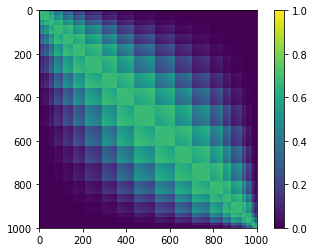

In [14]:
fig, ax = plt.subplots()
from matplotlib import colors
im = ax.imshow(kiss_linear_40_GP_cov, interpolation='nearest',vmin=0, vmax=1)
fig.colorbar(im)
plt.show()

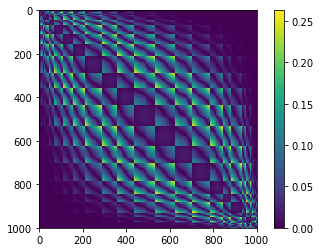

In [15]:
fig, ax = plt.subplots()
from matplotlib import colors
im = ax.imshow(abs(kiss_linear_40_GP_cov - exact_GP_cov), interpolation='nearest')
fig.colorbar(im)
plt.show()

In [16]:
grid_size = 150
kiss_linear_150_GP_cov_module = NewGridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            grid_size=grid_size, num_dims=1, interp_mode='linear')
kiss_linear_150_GP_cov = kiss_linear_150_GP_cov_module(X_tensor).evaluate().detach().numpy()


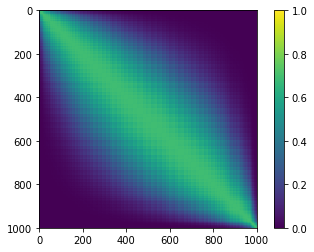

In [17]:
fig, ax = plt.subplots()
from matplotlib import colors
im = ax.imshow(kiss_linear_150_GP_cov, interpolation='nearest',vmin=0, vmax=1)
fig.colorbar(im)
plt.show()

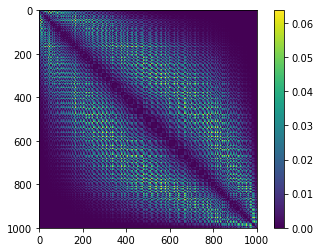

In [18]:
fig, ax = plt.subplots()
from matplotlib import colors
im = ax.imshow(abs(kiss_linear_150_GP_cov-exact_GP_cov), interpolation='nearest')
fig.colorbar(im)
plt.show()

# Implementing the kmeans grid method

In [19]:
grid_size = 15
os.chdir('/Users/naji/Box Sync/Box Sync/CMU/2019 Spring/ML with Large Datasets/Project/')
from kmeans_pytorch.kmeans import lloyd
choice_cluster, k_means_inducing_points = lloyd(X_tensor_arr.reshape((-1, 1)), grid_size)
k_means_inducing_points = torch.Tensor(k_means_inducing_points.reshape((1, -1)).squeeze())
print(k_means_inducing_points)
kmeans_5_GP_cov_module = gpytorch.kernels.InducingPointKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            inducing_points=k_means_inducing_points,
            likelihood=likelihood).float()
kmeans_5_GP_cov = kmeans_150_GP_cov_module(X_tensor).evaluate().detach().numpy()

tensor([-0.9389, -0.3043,  1.7275,  0.4615, -1.1976, -1.4758, -1.9290,  0.1684,
        -0.0771, -0.5163,  2.4237,  0.8090, -3.3177,  1.2722, -0.7058])


NameError: name 'kmeans_150_GP_cov_module' is not defined

NameError: name 'kmeans_150_GP_cov' is not defined

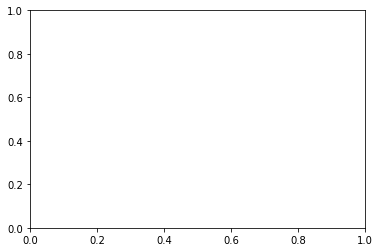

In [20]:
fig, ax = plt.subplots()
from matplotlib import colors
im = ax.imshow(abs(kmeans_150_GP_cov-exact_GP_cov), interpolation='nearest')
fig.colorbar(im)
plt.show()
print (kmeans_150_GP_cov-exact_GP_cov)

In [25]:
trials = range(5)
m_interval = range(4, 20)
trial_results = dict()

final_results = dict()
final_results['kmeans'] = []
final_results['fitc_linear'] = []
final_results['fitc_cubic'] = []
final_results['ski'] = []
# final_results['sor'] = []
method_list = ['ski', 'fitc_linear', 'fitc_cubic','kmeans']
import warnings
warnings.filterwarnings("error")

for m in m_interval:
    print ("doing m:", m)
    trial_results['ski'] = []
    trial_results['fitc_linear'] = []
    trial_results['fitc_cubic'] = []
    trial_results['kmeans'] = []
    
#     trial_results['ski'] = []
    for trial in trials:
        X_tensor = torch.randn(1000)
        X_tensor_arr = X_tensor.detach().numpy()
        X_tensor_arr.sort()
        X_tensor = torch.tensor(X_tensor_arr)
        min_x = torch.min(X_tensor).detach().numpy()
        max_x = torch.max(X_tensor).detach().numpy()
        inducing_points = torch.tensor(np.linspace(min_x, max_x, m))
        grid_size = m


        exact_gp_cov_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        exact_GP_cov = exact_gp_cov_module(X_tensor).evaluate().detach().numpy()

        kiss_GP_cov_module = gpytorch.kernels.GridInterpolationKernel(
                    gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
                    grid_size=grid_size, num_dims=1)
        kiss_GP_cov = kiss_GP_cov_module(X_tensor).evaluate().detach().numpy()



        likelihood = gpytorch.likelihoods.GaussianLikelihood()

        FITC_linear_GP_cov_module = NewGridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            grid_size=grid_size, num_dims=1, interp_mode='linear')
        FITC_linear_GP_cov = FITC_linear_GP_cov_module(X_tensor).evaluate().detach().numpy()

        FITC_cubic_GP_cov_module = NewGridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            grid_size=grid_size, num_dims=1, interp_mode='cubic')
        FITC_cubic_GP_cov = FITC_cubic_GP_cov_module(X_tensor).evaluate().detach().numpy()

        error_maybe = True
        while error_maybe:
            choice_cluster, k_means_inducing_points = lloyd(X_tensor_arr.reshape((-1, 1)), grid_size)
            k_means_inducing_points = torch.Tensor(k_means_inducing_points.reshape((1, -1)).squeeze())


            kmeans_GP_cov_module = gpytorch.kernels.InducingPointKernel(
                        gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
                        inducing_points=k_means_inducing_points,
                        likelihood=likelihood).float()
            try:
                kmeans_GP_cov = kmeans_GP_cov_module(X_tensor).evaluate().detach().numpy()
                error_maybe = False
            except Exception as e:
                print ("erorr happened")
                continue
            error_maybe = False
            
#         trial_results['kmeans'].append(abs(kmeans_GP_cov-exact_GP_cov).mean())
        trial_results['fitc_cubic'].append(abs(FITC_cubic_GP_cov-exact_GP_cov).mean())
        trial_results['fitc_linear'].append(abs(FITC_linear_GP_cov-exact_GP_cov).mean())
        trial_results['ski'].append(abs(kiss_GP_cov-exact_GP_cov).mean())
        trial_results['kmeans'].append(abs(kmeans_GP_cov-exact_GP_cov).mean())
    for method in method_list:
        final_results[method].append(np.asarray(trial_results[method]).mean())
    
fig, ax = plt.subplots()
for method in method_list:
    ax.plot(final_results[method], label=method)
fig.legend()

doing m: 4
doing m: 5
doing m: 6
doing m: 7
doing m: 8
doing m: 9


KeyboardInterrupt: 